In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import joblib
import time
import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_path = "../data/Hybrid_IDS2017_2018_2019/final_dataset.csv"

TARGET_PER_CLASS = 500000 
CHUNK_SIZE = 100000

df_benign_list = []
df_ddos_list = []
benign_count = 0
ddos_count = 0

print("Veri seti taranıyor ve dengeli örneklem toplanıyor...")

# Dosyayı parça parça okuyoruz
for chunk in pd.read_csv(data_path, chunksize=CHUNK_SIZE):
    
    # Sütun adlarını temizliyoruz
    chunk.columns = chunk.columns.str.strip()
    
    # Bu chunk içindeki Benign ve DDoS'ları ayıracağız
    benign_chunk = chunk[chunk['Label'] == 'Benign']
    ddos_chunk = chunk[chunk['Label'] != 'Benign'] # DDoS
    
    # Yeterli sayıya ulaşmadıysak listeye ekle
    if benign_count < TARGET_PER_CLASS:
        # İhtiyaç kadarını al
        needed = TARGET_PER_CLASS - benign_count
        to_take = benign_chunk.head(needed)
        df_benign_list.append(to_take)
        benign_count += len(to_take)
        
    if ddos_count < TARGET_PER_CLASS:
        needed = TARGET_PER_CLASS - ddos_count
        to_take = ddos_chunk.head(needed)
        df_ddos_list.append(to_take)
        ddos_count += len(to_take)
        
    # İki sınıftan da yeterince topladıysak döngüyü kır
    if benign_count >= TARGET_PER_CLASS and ddos_count >= TARGET_PER_CLASS:
        print("Hedeflenen veri sayısına ulaşıldı!")
        break

df_benign = pd.concat(df_benign_list)
df_ddos = pd.concat(df_ddos_list)

df = pd.concat([df_benign, df_ddos])
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # karıştırma işlemi

print(f"Toplam Veri: {len(df)}")
print(f"Sınıf Dağılımı:\n{df['Label'].value_counts()}")

Veri seti taranıyor ve dengeli örneklem toplanıyor...
Hedeflenen veri sayısına ulaşıldı!
Toplam Veri: 1000000
Sınıf Dağılımı:
Label
ddos      500000
Benign    500000
Name: count, dtype: int64


In [4]:
SELECTED_FEATURES = [
    'Flow Duration', 
    'Tot Fwd Pkts', 
    'Tot Bwd Pkts', 
    'TotLen Fwd Pkts', 
    'TotLen Bwd Pkts', 
    'Fwd Pkt Len Max', 
    'Fwd Pkt Len Min', 
    'Label' 
]

In [5]:
try:
    df = df[SELECTED_FEATURES]
except KeyError as e:
    print(f"Hata: Sütun ismi bulunamadı. Lütfen df.columns çıktısını kontrol et. Hata: {e}")
    drop_cols = ['Flow ID', 'Src IP','Dst IP', 'Src Port','Dst Port','Timestamp']
    existing_drop = [c for c in drop_cols if c in df.columns]
    df.drop(columns=existing_drop, inplace=True)

In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Label encoding
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

In [7]:
X = df.drop(columns=['Label'])
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify = y)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state = 0),
    "Random Forest": RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state = 0), # n_jobs=-1 tüm işlemcileri kullanır
    "Logistic Regression": LogisticRegression(max_iter = 1000, n_jobs=-1, random_state = 0),
    
    # Boosting Modelleri
    "XGBoost": XGBClassifier(
        eval_metric = 'mlogloss', 
        use_label_encoder = False, 
        n_jobs = -1, 
        random_state = 0
    ),
    "LightGBM": LGBMClassifier(
        n_jobs = -1, 
        random_state = 0, 
        verbose = -1 # loglar kapalı
    ),
    "CatBoost": CatBoostClassifier(
        verbose = 0, # loglar kapalı
        random_state = 42,
        thread_count = -1
    )
}

results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "CV Mean Score", "Time"])

In [10]:
print(f"{'-'*20} EĞİTİM BAŞLIYOR {'-'*20}")
print(f"Toplam Veri Sayısı: {len(df)}")
print(f"Modeller: {', '.join(models.keys())}\n")

# EĞİTİM DÖNGÜSÜ
for name, model in models.items():
    start_time = time.time()
    
    # Boosting ve Ağaçlar için ölçeklenmemiş, LogReg için ölçeklenmiş veri kullanalıyorum
    # Not: Boosting algoritmaları ölçekli veriyle de gayet iyi çalışır.
    if name == "Logistic Regression":
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
        
    # Model eğitimi
    model.fit(X_tr, y_train)
    
    # Tahmin
    y_pred = model.predict(X_te)
    
    # Metrikler
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Cross Validation 
    # 1 Milyondan fazla satır olduğu için cv 3'e düşürüldü
    cv_scores = cross_val_score(model, X_tr, y_train, cv = 3, scoring = 'f1_macro', n_jobs = -1)
    cv_mean = cv_scores.mean()
    
    elapsed_time = time.time() - start_time
    
    # Kayıtlar
    new_row = pd.DataFrame({
        "Model": [name], "Accuracy": [acc], "Precision": [prec], 
        "Recall": [rec], "F1-Score": [f1], "CV Mean Score": [cv_mean],
        "Time": [round(elapsed_time, 2)]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    print(f"Model Tamamlandı: {name} (Süre: {elapsed_time:.2f}sn)")

# SONUÇLARI SIRALA VE GÖSTER
results_df = results_df.sort_values(by = "F1-Score", ascending = False).reset_index(drop = True) # F1-Score'a göre model sıralaması

-------------------- EĞİTİM BAŞLIYOR --------------------
Toplam Veri Sayısı: 1000000
Modeller: Decision Tree, Random Forest, Logistic Regression, XGBoost, LightGBM, CatBoost

Model Tamamlandı: Decision Tree (Süre: 8.23sn)
Model Tamamlandı: Random Forest (Süre: 83.62sn)
Model Tamamlandı: Logistic Regression (Süre: 5.30sn)
Model Tamamlandı: XGBoost (Süre: 7.63sn)
Model Tamamlandı: LightGBM (Süre: 6.43sn)
Model Tamamlandı: CatBoost (Süre: 160.80sn)


In [11]:
print("\n" + "="*60)
print("PERFORMANS SIRALAMASI (F1-SCORE BAZLI)")
print("="*60)
print(results_df)


PERFORMANS SIRALAMASI (F1-SCORE BAZLI)
                 Model  Accuracy  Precision   Recall  F1-Score  CV Mean Score  \
0        Random Forest   0.99351   0.993510  0.99351  0.993510       0.993303   
1        Decision Tree   0.99306   0.993060  0.99306  0.993060       0.992767   
2              XGBoost   0.99296   0.992961  0.99296  0.992960       0.992808   
3             CatBoost   0.99285   0.992850  0.99285  0.992850       0.992567   
4             LightGBM   0.99263   0.992630  0.99263  0.992630       0.992358   
5  Logistic Regression   0.78062   0.809921  0.78062  0.775309       0.771903   

     Time  
0   83.62  
1    8.23  
2    7.63  
3  160.80  
4    6.43  
5    5.30  



En İyi Model: Random Forest ile görselleştirme yapılıyor...


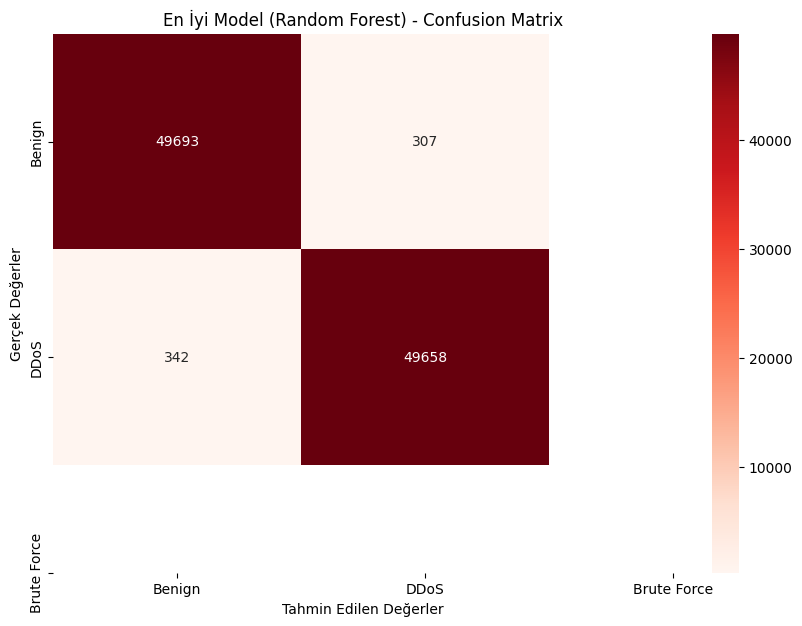

In [12]:
# En iyi modeli seçip confusion matrixine bir bakalım
best_model_name = results_df.iloc[0]["Model"]

print(f"\nEn İyi Model: {best_model_name} ile görselleştirme yapılıyor...")

best_model = models[best_model_name]

# Log Reg modeline scaled veri vermiştik onu unutmayalım
if best_model_name == "Logistic Regression":
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test) # Diğer modeller scaled olmasa da çalışır

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Benign', 'DDoS', 'Brute Force'], 
            yticklabels=['Benign', 'DDoS', 'Brute Force'])
plt.title(f'En İyi Model ({best_model_name}) - Confusion Matrix')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()


 MODELLERE GÖRE EN ÖNEMLİ 7 ÖZELLİK

--- Decision Tree ---
Tot Fwd Pkts                   : 0.31835
Tot Bwd Pkts                   : 0.21641
Fwd Pkt Len Min                : 0.19889
Flow Duration                  : 0.13073
TotLen Bwd Pkts                : 0.06415
Fwd Pkt Len Max                : 0.05429
TotLen Fwd Pkts                : 0.01718

--- Random Forest ---
Flow Duration                  : 0.20402
Tot Fwd Pkts                   : 0.19179
Tot Bwd Pkts                   : 0.16977
Fwd Pkt Len Min                : 0.14083
TotLen Bwd Pkts                : 0.11551
Fwd Pkt Len Max                : 0.09754
TotLen Fwd Pkts                : 0.08054

--- Logistic Regression ---
Fwd Pkt Len Min                : 2.14135
TotLen Bwd Pkts                : 1.03763
Tot Bwd Pkts                   : 1.02890
Flow Duration                  : 0.47332
Fwd Pkt Len Max                : 0.41865
TotLen Fwd Pkts                : 0.29858
Tot Fwd Pkts                   : 0.24427

--- XGBoost ---
Fwd Pkt Le

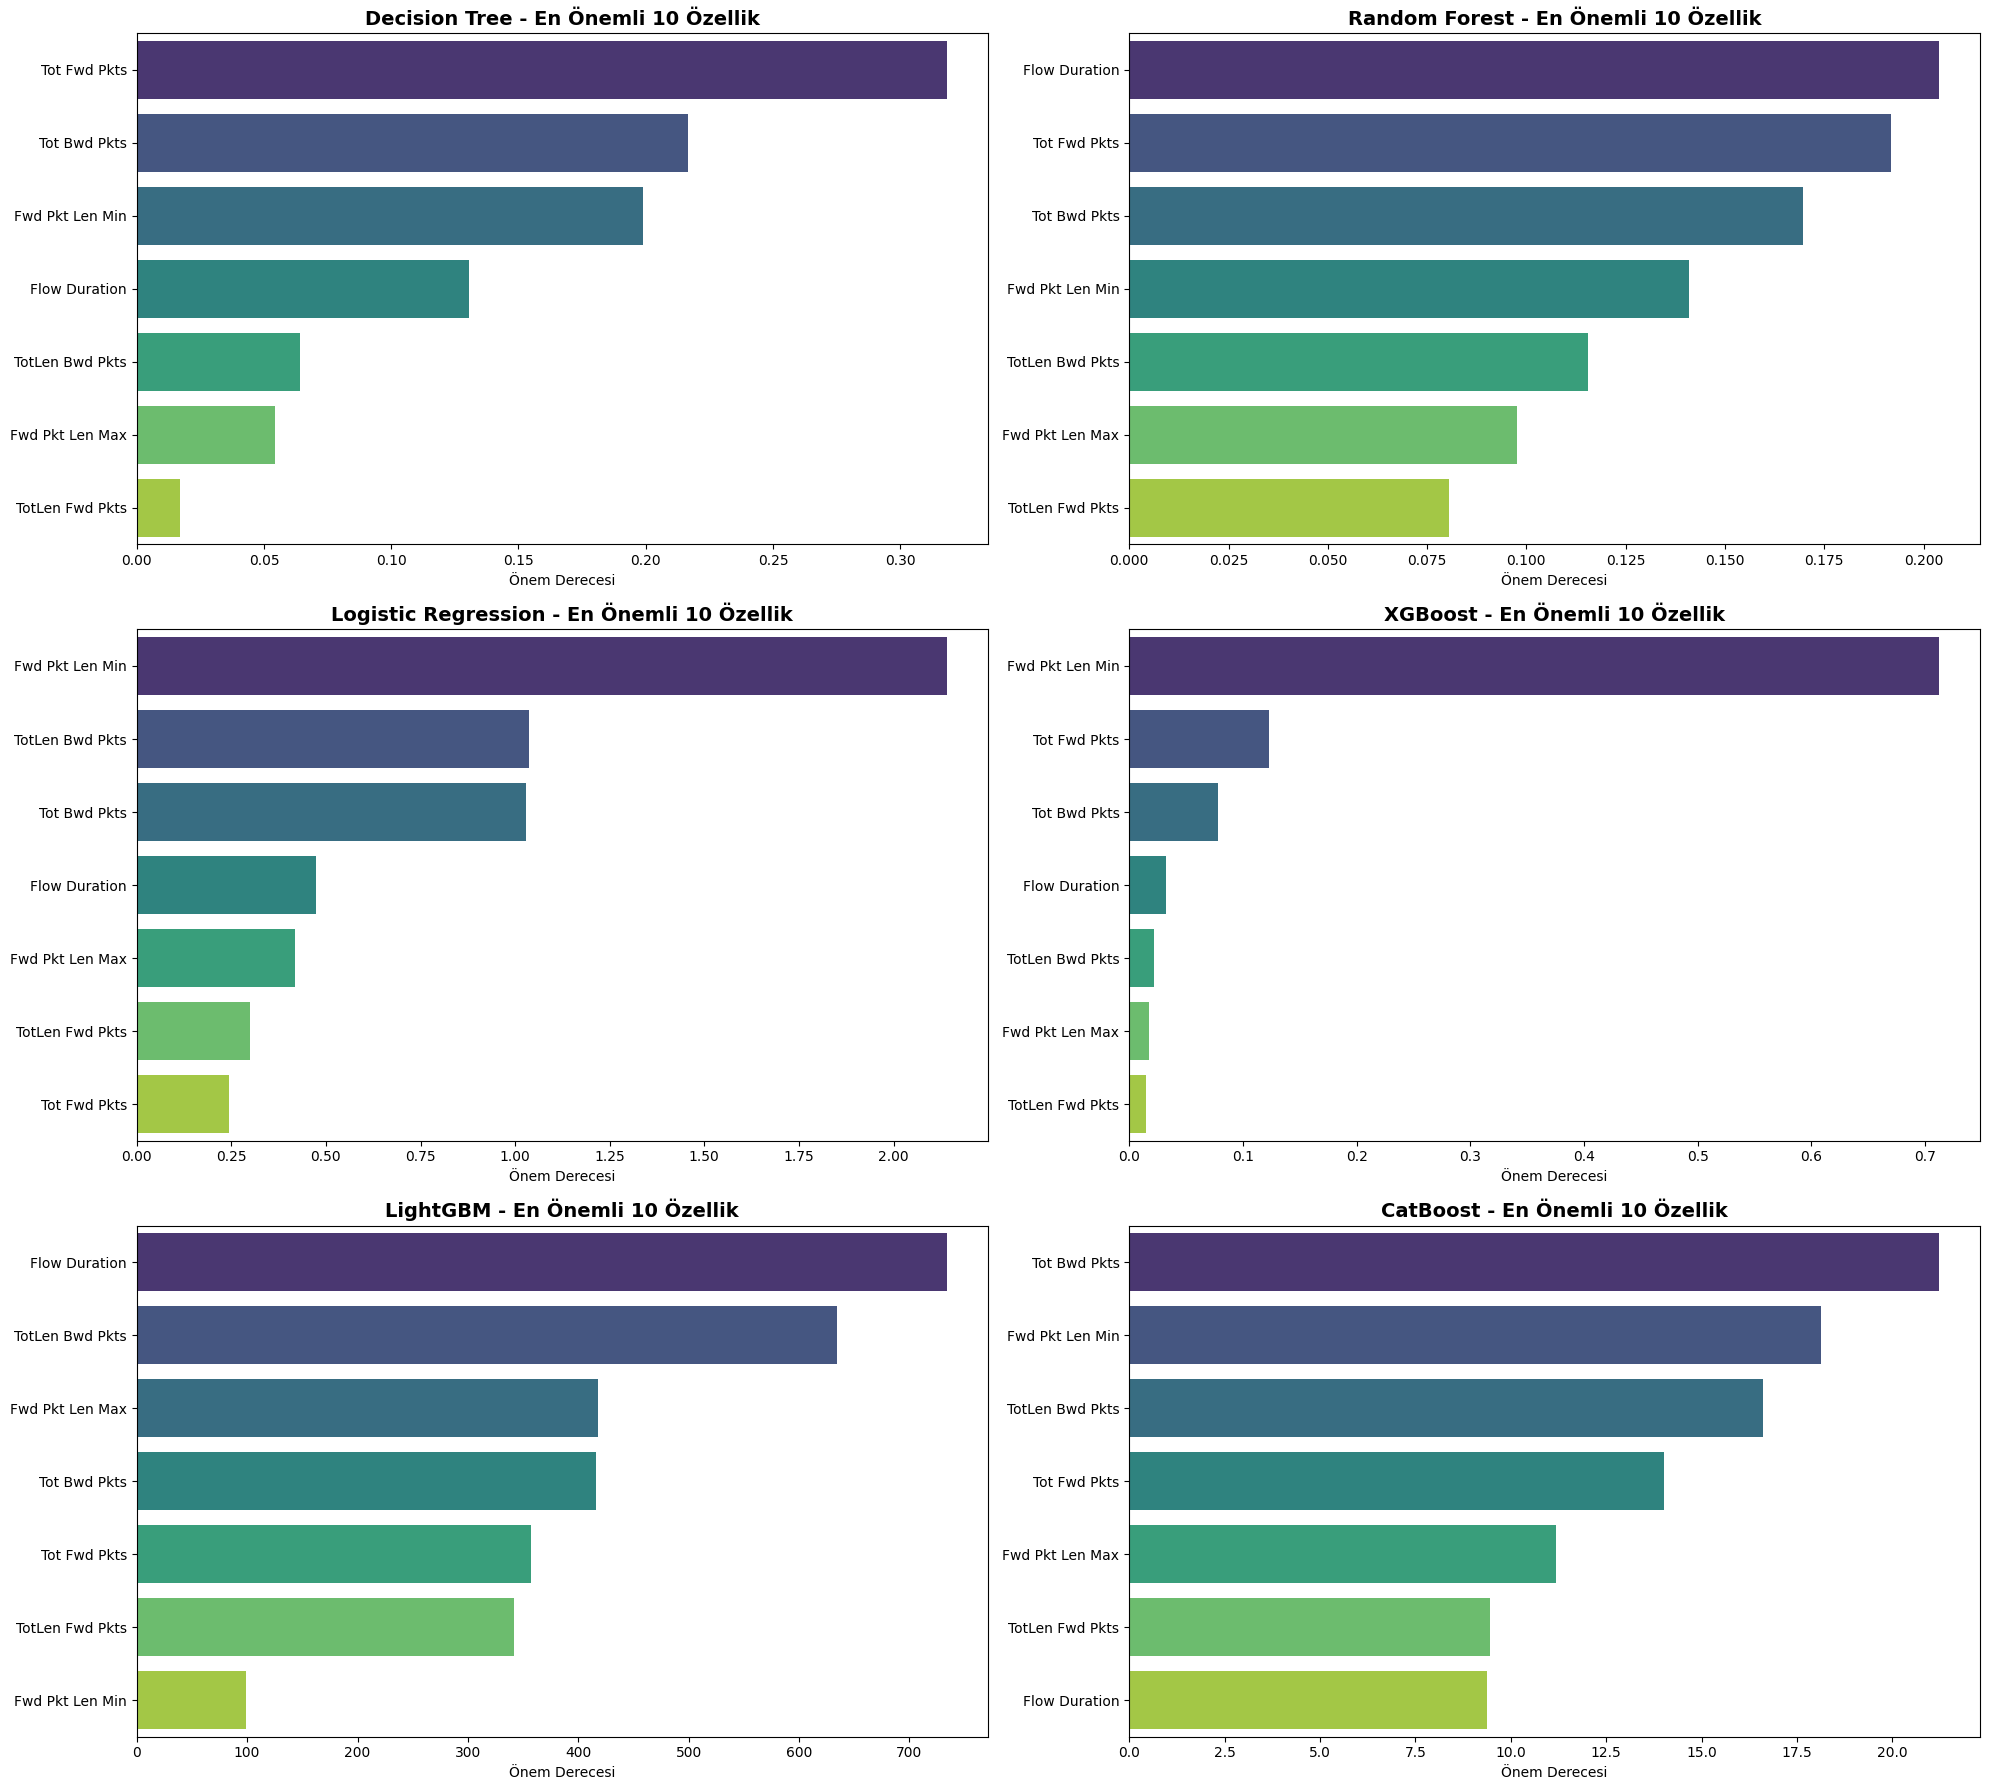

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))
axes = axes.flatten()

feature_names = X.columns

print("\n" + "="*40)
print(" MODELLERE GÖRE EN ÖNEMLİ 7 ÖZELLİK")
print("="*40)

for i, (name, model) in enumerate(models.items()):
    # Önem Değerlerini Çekme
    try:
        if name == "Logistic Regression":
            # Logistic Regression katsayı kullanır.
            # 3 sınıf olduğu için katsayıların mutlak değerlerinin ortalamasını alıyoruz.
            importances = np.mean(np.abs(model.coef_), axis=0)
        elif name == "CatBoost":
            importances = model.get_feature_importance()
        else:
            # Diğer ağaç tabanlı modeller için fonksiyon ismi aynı
            importances = model.feature_importances_
            
        # DataFrame Oluşturma ve Sıralama İşlemi
        feature_imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        
        # En yüksek 10 özelliği seçiyoruz
        top_10 = feature_imp_df.sort_values(by = 'Importance', ascending = False).head(10)
        
        # Yazılı Çıktılar
        print(f"\n--- {name} ---")
        for index, row in top_10.iterrows():
            print(f"{row['Feature']:<30} : {row['Importance']:.5f}")
            
        # Görselleştirme
        sns.barplot(x='Importance', y='Feature', data = top_10, ax = axes[i], palette = 'viridis')
        axes[i].set_title(f'{name} - En Önemli 10 Özellik', fontsize = 14, fontweight = 'bold')
        axes[i].set_xlabel('Önem Derecesi')
        axes[i].set_ylabel('')
        
    except Exception as e:
        print(f"{name} için feature importance hesaplanamadı: {e}")
        # Hata durumunda boş grafiği gizleyecek
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [16]:
import joblib
import os

print("Modeller Kaydediliyor...")
for name, model in models.items():
    save_path = f"../models/Binary_Models/Model/benign_ddos_{name}_final.pkl"
    joblib.dump(model, save_path)
    print(f"Model başarıyla '{save_path}' olarak kaydedildi.")
print("Model Kayıt İşlemi Başarıyla Tamamlandı!")

Modeller Kaydediliyor...
Model başarıyla '../models/Binary_Models/Model/benign_ddos_Decision Tree_final.pkl' olarak kaydedildi.
Model başarıyla '../models/Binary_Models/Model/benign_ddos_Random Forest_final.pkl' olarak kaydedildi.
Model başarıyla '../models/Binary_Models/Model/benign_ddos_Logistic Regression_final.pkl' olarak kaydedildi.
Model başarıyla '../models/Binary_Models/Model/benign_ddos_XGBoost_final.pkl' olarak kaydedildi.
Model başarıyla '../models/Binary_Models/Model/benign_ddos_LightGBM_final.pkl' olarak kaydedildi.
Model başarıyla '../models/Binary_Models/Model/benign_ddos_CatBoost_final.pkl' olarak kaydedildi.
Model Kayıt İşlemi Başarıyla Tamamlandı!
